## Introduction

#### create a model to get an ideally functioning turbine’s expected rotor bearing temperature.

### Import the necessary packages.

In [1]:
!pip install klib -q

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
#import klib

from scipy.stats import skew, kurtosis
from prettytable import PrettyTable

### Import train and test dataset

In [3]:
train=pd.read_csv("../input/renew-data-machinehack/train.csv")
test=pd.read_csv("../input/renew-data-machinehack/test.csv")

### Change column names in train and test dataset to lowercase.

In [4]:
train=train.rename(columns={col:col.lower()   for col in train.columns.values})
test=test.rename(columns={col:col.lower()  for col in test.columns.values})

### Structure of the train and test dataset.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909604 entries, 0 to 909603
Data columns (total 16 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               909604 non-null  object 
 1   active_power_calculated_by_converter    909604 non-null  float64
 2   active_power_raw                        909604 non-null  float64
 3   ambient_temperature                     909604 non-null  float64
 4   generator_speed                         909604 non-null  float64
 5   generator_winding_temp_max              909604 non-null  float64
 6   grid_power10min_average                 909604 non-null  float64
 7   nc1_inside_temp                         909604 non-null  float64
 8   nacelle_temp                            909604 non-null  float64
 9   reactice_power_calculated_by_converter  909604 non-null  float64
 10  reactive_power                          9096

#### The above information shows that there are 909604 data entries and 16 columns.

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303202 entries, 0 to 303201
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               303202 non-null  object 
 1   active_power_calculated_by_converter    303202 non-null  float64
 2   active_power_raw                        303202 non-null  float64
 3   ambient_temperature                     303202 non-null  float64
 4   generator_speed                         303202 non-null  float64
 5   generator_winding_temp_max              303202 non-null  float64
 6   grid_power10min_average                 303202 non-null  float64
 7   nc1_inside_temp                         303202 non-null  float64
 8   nacelle_temp                            303202 non-null  float64
 9   reactice_power_calculated_by_converter  303202 non-null  float64
 10  reactive_power                          3032

#### The above information shows that there are 303202 data entries and 15 columns.

### Let's see is there any missing values in train and test dataset by column wise.

In [32]:
train.isnull().sum()

timestamp                                 0
active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
turbine_id                                0
target                                    0
dtype: int64

#### The above information shows that there are no missing values.

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303202 entries, 0 to 303201
Data columns (total 15 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   timestamp                               303202 non-null  object 
 1   active_power_calculated_by_converter    303202 non-null  float64
 2   active_power_raw                        303202 non-null  float64
 3   ambient_temperature                     303202 non-null  float64
 4   generator_speed                         303202 non-null  float64
 5   generator_winding_temp_max              303202 non-null  float64
 6   grid_power10min_average                 303202 non-null  float64
 7   nc1_inside_temp                         303202 non-null  float64
 8   nacelle_temp                            303202 non-null  float64
 9   reactice_power_calculated_by_converter  303202 non-null  float64
 10  reactive_power                          3032

#### The above information shows that there are no missing values.

### Let's see the glimpse of train dataset

In [34]:
train.head(2)

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328


### Let's create a function to display the catgeorical column level counts.

In [5]:
def count_plot(df,col,rot=None,switchax=None,size=(8,6),title=''):
    _=plt.figure(figsize=size)
    if switchax:
        _=sns.countplot(y=df[col],order=df[col].value_counts().index);
        _=plt.title(title,fontsize=25)
        _=plt.ylabel(col,fontsize=20)
        _=plt.yticks(fontsize=14,rotation=rot)   

    else:
        _=sns.countplot(x=df[col],order=df[col].value_counts().index);
        _=plt.title(title,fontsize=25)
        _=plt.xlabel(col,fontsize=20)
        _=plt.xticks(fontsize=14,rotation=rot)   


### Let's create a function for box plot.

In [7]:
def box_plot(df,col,rot=None,title=""):
    _=plt.figure(figsize=(8,6))
    _=sns.boxplot(y=df[col])
    _=plt.title(title+" Distribution",fontsize=25)
    _=plt.ylabel(col,fontsize=20,rotation=rot)
    _=plt.yticks(fontsize=14)


### Let's create a function for side by side plot(density and group-wise boxplot).

In [8]:
def side_by_side_plot(df,grp,valcol,rot=None):
    clr="Paired"
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    sns.kdeplot(x=df[valcol], hue=df[grp],ax=ax1,palette=clr)
    ax1.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax1.set_xlabel(valcol,fontsize=20)
    sns.boxplot(x=df[grp],y=df[valcol],ax=ax2,palette=clr)
    ax2.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax2.set_xlabel(grp,fontsize=20)
    ax2.tick_params(rotation=rot)

### Let's create a function for group by numerical summary.

In [9]:
def group_summary(df,groupcol,value):
    return df.groupby(groupcol)[value].describe().reset_index().sort_values('mean',ascending=False)

### Let's see the target column distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Figure size 1080x720 with 0 Axes>

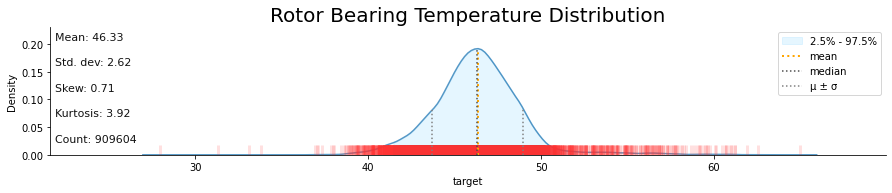

In [9]:
plt.figure(figsize=(15,10))
klib.dist_plot(train['target']);
plt.title("Rotor Bearing Temperature Distribution",fontsize=20);

In [40]:
train['target'].describe()

count    909604.000000
mean         46.328595
std           2.617691
min          25.865320
25%          44.816740
50%          46.302899
75%          47.733105
max          65.037689
Name: target, dtype: float64

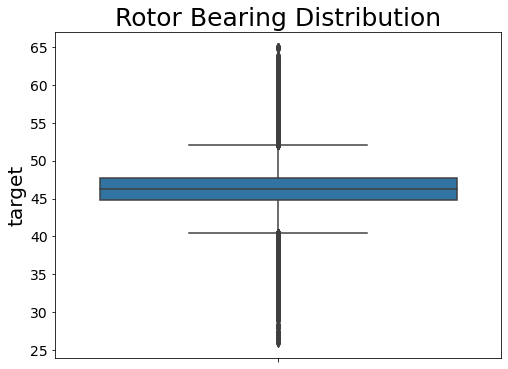

In [8]:
box_plot(train,'target',rot=90,title="Rotor Bearing")

#### The above histogram explains that the target(rotor bearing temperature) column is normally distrributed.

#### The rotor bearing temperature ranges from 2.6 to 65.03.

#### The average rotor bearing temperature is 46.32.

#### The boxplot explains that there are outliers below the first quartile and above the third quartile.

### Let's see the numerical columns distribution by using kernel density plot.

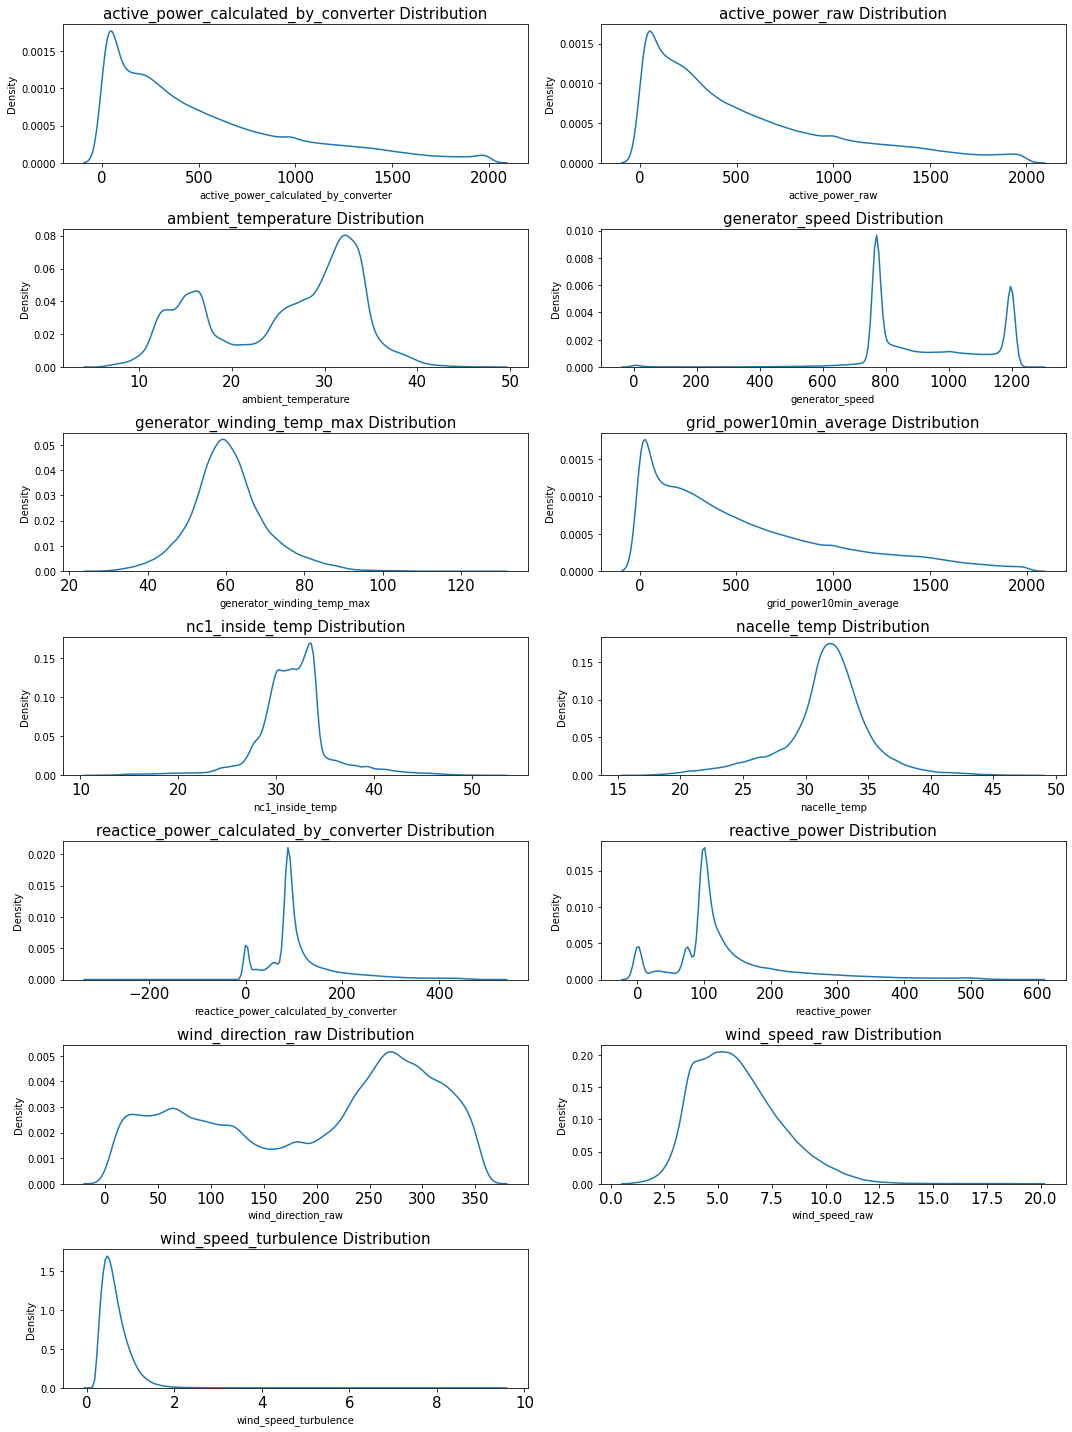

In [11]:
fig=plt.subplots(figsize=(15, 20))
for i,col  in enumerate(train.iloc[:,1:14].columns.values):    
       _=plt.subplot(7,2,i+1)
       _=sns.kdeplot(x=train[col])
       _=plt.title(col+' Distribution',fontsize=15)
       _=plt.xlabel(col,fontsize=10)
       _=plt.xticks(fontsize=15)
       _=plt.tight_layout()  
plt.show()  

In [21]:
kde_plot_summary = PrettyTable([i.capitalize() for i in['name','skew','kurtosis','mean','median','mean>median']])
kde_plot_summary.align['Name']="l"
for field in ['skew','kurtosis','mean','median']:
    kde_plot_summary.align[field]="r"
    


for num, col  in enumerate(train.iloc[:,1:14].columns.values):
    d=list()
    d.append(f"{num+1}.{col.capitalize()}")

    d.append(round(skew(train[col], axis=0, bias=True),3))
    d.append(round(kurtosis(train[col], axis=0, bias=True),3))
    d.append(round(train[col].describe()[1],3))
    d.append(round(train[col].describe()[6],3))
    d.append(train[col].describe()[1]>train[col].describe()[6])
    kde_plot_summary.add_row(d)

In [103]:
kde_plot_summary

Name,Skew,Kurtosis,Mean,Median,Mean>median
1.Active_power_calculated_by_converter,1.095,0.461,525.886,781.357,False
2.Active_power_raw,1.08,0.356,537.639,800.261,False
3.Ambient_temperature,-0.406,-1.103,25.574,32.172,False
4.Generator_speed,-0.433,1.561,931.131,1123.336,False
5.Generator_winding_temp_max,0.483,1.218,60.73,65.737,False
6.Grid_power10min_average,1.008,0.235,527.58,794.876,False
7.Nc1_inside_temp,0.041,4.299,31.756,33.47,False
8.Nacelle_temp,-0.428,1.922,31.686,33.546,False
9.Reactice_power_calculated_by_converter,1.731,4.081,111.081,124.879,False
10.Reactive_power,1.638,3.538,133.692,154.154,False


#### The above density plot and summary explains that all the numeric columns in the train dataset are skewed(either postively or negatively).

### Let's see the numerical columns distribution by using boxplot.

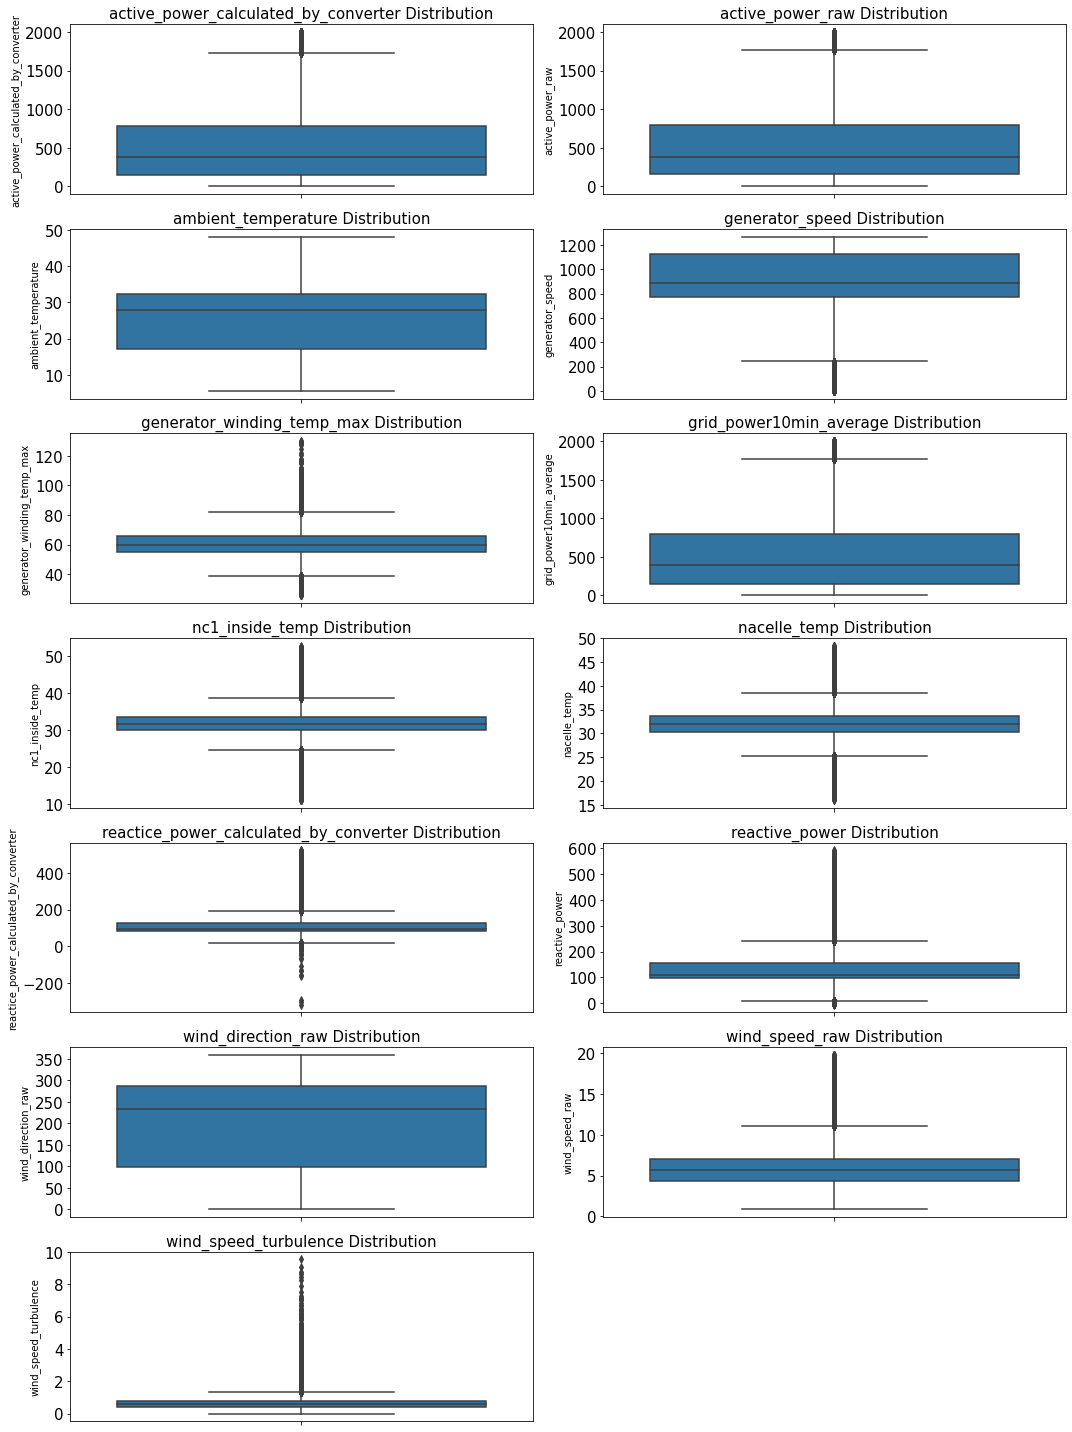

In [13]:
fig=plt.subplots(figsize=(15, 20))
for i,col  in enumerate(train.iloc[:,1:14].columns.values):    
       _=plt.subplot(7,2,i+1)
       _=sns.boxplot(y=train[col])
       _=plt.title(col+' Distribution',fontsize=15)
       _=plt.ylabel(col,fontsize=10)
       _=plt.yticks(fontsize=15)
       _=plt.tight_layout()  
plt.show()  

In [11]:
box_plot_summary = PrettyTable([i.capitalize() for i in['name', 'min', 'Q1-25%', 'Q2(Median)50%', 'Q3-75%', 'max','iqr','lower limit','upper limit','outlier']])
box_plot_summary.align["Name"] = "l"

for num, col  in enumerate(train.iloc[:,1:14].columns.values):
    d=list()
    d.append(f"{num+1}.{col.capitalize()}")
    d.append(round(train[col].describe()[3],3))
    d.append(round(train[col].describe()[4],3))
    d.append(round(train[col].describe()[5],3))
    d.append(round(train[col].describe()[6],3))
    d.append(round(train[col].describe()[7],3))
    d.append(round(train[col].describe()[6]-train[col].describe()[4],3))
    low_limit=round(train[col].describe()[4]-1.5*(train[col].describe()[6]-train[col].describe()[4]),3)
    up_limit=round(train[col].describe()[6]+1.5*(train[col].describe()[6]-train[col].describe()[4]),3)
    d.append(low_limit)
    d.append(low_limit)
    d.append(any([(any(i < low_limit for i in train[col].values)), (any(i > up_limit for i in train[col].values))]))
    
    box_plot_summary.add_row(d)
  
    
  

In [12]:
box_plot_summary

Name,Min,Q1-25%,Q2(median)50%,Q3-75%,Max,Iqr,Lower limit,Upper limit,Outlier
1.Active_power_calculated_by_converter,0.0,149.621,379.99,781.357,2000.0,631.737,-797.984,-797.984,True
2.Active_power_raw,0.0,155.813,383.986,800.261,1999.984,644.448,-810.859,-810.859,True
3.Ambient_temperature,5.617,17.094,27.919,32.172,48.089,15.078,-5.523,-5.523,False
4.Generator_speed,0.0,770.539,884.069,1123.336,1267.141,352.797,241.343,241.343,True
5.Generator_winding_temp_max,25.636,54.917,60.034,65.737,129.846,10.82,38.686,38.686,True
6.Grid_power10min_average,0.0,147.182,391.303,794.876,1999.991,647.694,-824.36,-824.36,True
7.Nc1_inside_temp,11.142,29.914,31.763,33.47,52.79,3.556,24.58,24.58,True
8.Nacelle_temp,16.01,30.267,31.962,33.546,48.406,3.279,25.349,25.349,True
9.Reactice_power_calculated_by_converter,-318.394,81.541,92.006,124.879,523.893,43.338,16.533,16.533,True
10.Reactive_power,-5.462,96.046,107.633,154.154,592.816,58.108,8.884,8.884,True


#### The above boxplot and summary explain that there are outliers(based on the turkey fences) in all numeric columns of the training dataset except the columns ambient temperature and wind direction raw.

### Let's see the correlation between the numerical columns.

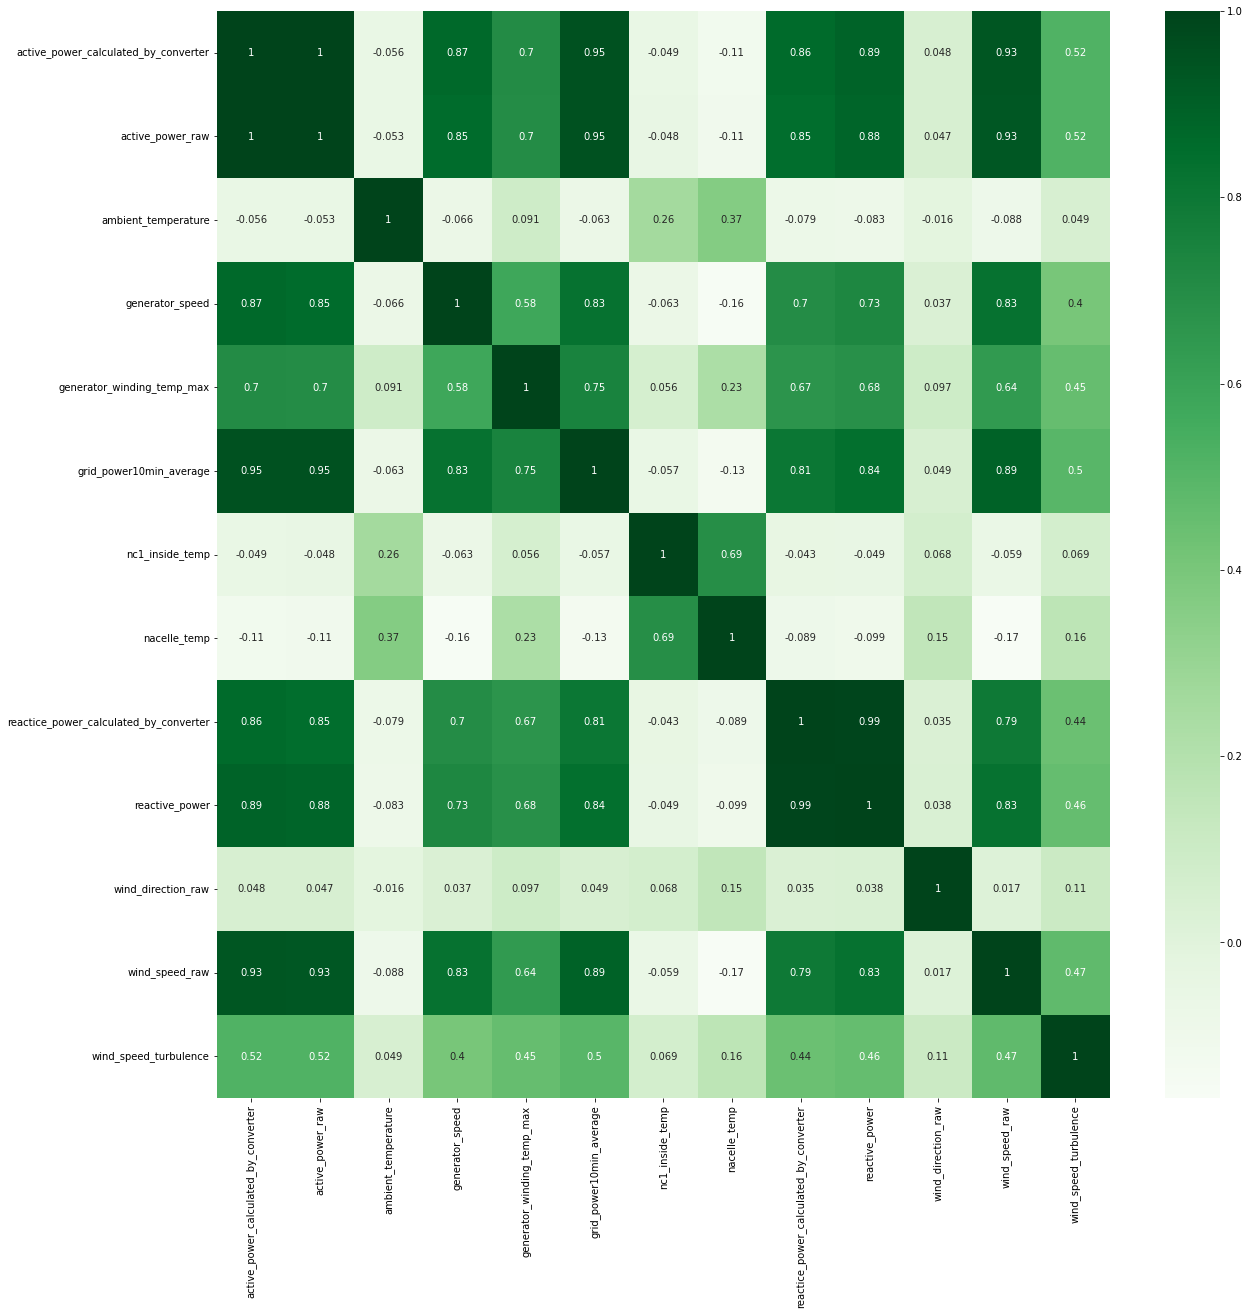

In [58]:
plt.figure(figsize=(20,20))
sns.heatmap(train.iloc[:,1:14].corr(),fmt='.2g',annot=True,cmap='Greens');

In [50]:
def corr_features(df,threshold,target):
    corr_list=df.corr().loc[target].drop(target)
    return corr_list[corr_list>threshold]
   

In [57]:
for num ,i in enumerate(train.iloc[:,np.r_[1:14,15]]):
  
    result=corr_features(train.iloc[:,np.r_[1:14,15]] ,0.7,i)
    if len(result) > 0:
        print("="*100)
        print(f"The {i} Column is Highly Correlated with Following Features \n")
        print(result)
        print("-"*100)
    else:
        pass

The active_power_calculated_by_converter Column is Highly Correlated with Following Features 

active_power_raw                          0.996435
generator_speed                           0.865399
generator_winding_temp_max                0.704785
grid_power10min_average                   0.951129
reactice_power_calculated_by_converter    0.859807
reactive_power                            0.890428
wind_speed_raw                            0.933014
Name: active_power_calculated_by_converter, dtype: float64
----------------------------------------------------------------------------------------------------
The active_power_raw Column is Highly Correlated with Following Features 

active_power_calculated_by_converter      0.996435
generator_speed                           0.854905
generator_winding_temp_max                0.700618
grid_power10min_average                   0.950450
reactice_power_calculated_by_converter    0.846891
reactive_power                            0.880181
wind_sp

#### The above plot explains that there is a high positive correlation between the independent numeric columns.

### Let's see various wind turbines and their rotor-bearing temperature distribution.

In [60]:
train['turbine_id'].nunique()

16

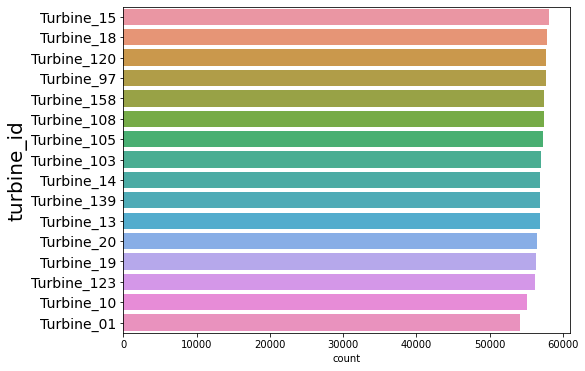

In [64]:
count_plot(train,'turbine_id',switchax=True)

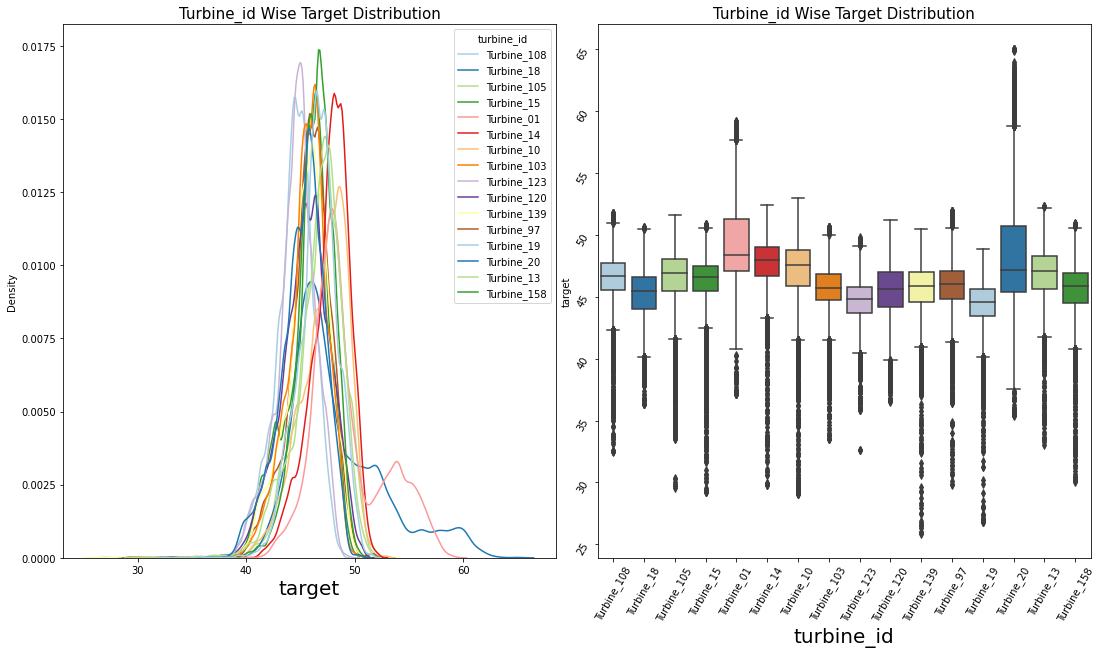

In [65]:
side_by_side_plot(train,'turbine_id','target',rot=60)

In [66]:
group_summary(train,'turbine_id','target')

,turbine_id,count,mean,std,min,25%,50%,75%,max
0,Turbine_01,54171.0,49.288458,3.342025,37.141447,47.072317,48.370728,51.315307,59.156406
14,Turbine_20,56523.0,48.420630,4.296550,35.402102,45.416581,47.143988,50.751029,65.037689
9,Turbine_14,56934.0,47.722849,1.883557,29.793389,46.708989,47.999722,48.996160,52.393883
1,Turbine_10,55089.0,47.186210,2.236599,29.052082,45.890360,47.576019,48.808872,52.995842
7,Turbine_13,56853.0,46.855068,2.051979,33.037130,45.648151,47.072433,48.252111,52.313429
3,Turbine_105,57341.0,46.585878,2.211376,29.526246,45.470722,46.940166,48.079488,51.588160
4,Turbine_108,57401.0,46.549006,1.834950,32.470976,45.568690,46.639037,47.723272,51.784840
10,Turbine_15,58048.0,46.388378,1.723327,29.212526,45.491136,46.560881,47.513386,50.914379
15,Turbine_97,57683.0,45.834314,1.924943,29.824291,44.814643,46.002502,47.110703,51.910770
8,Turbine_139,56930.0,45.643603,2.015872,25.865320,44.572909,45.848046,47.010976,50.511377


#### The above plot explains that there is a significant difference in the rotor-bearing temperature of wind turbines.